# Introduction

This project will show how to use YOLO (You Only Look Once) object detector to detect objects in both images and streams from a camera, using Python, OpenCV and deep learning.

We can run this either on a Windows laptop with intergrated camera, or Raspberry Pi with USB camera.

This code is hosted at: https://github.com/xiaodongzhao/pi_opencv_project

## Requirements

- [Python 3.x](https://www.python.org/downloads/): the programing language
- [Numpy](https://www.numpy.org/): for matrix operations
- [Matplotlib](https://matplotlib.org/): for plotting
- [OpenCV](https://opencv.org/): image processing
- [Configuration and pre-trained weights for YOLO v3 and YOLO v3 tiny](https://pjreddie.com/darknet/yolo/): for object detection
- [Raspberry Pi](https://www.raspberrypi.org/) with USB camera (optional)
- or Windows laptop with camera

## Outline

1. Enviroment setup
2. Build YOLO object detector using OpenCV
3. Use YOLO to detect objects from an image
4. Use YOLO to detect objects from a camera 

# Enviroment setup

## Python and OpenCV

- Python: an interpreted, high-level, general-purpose programming language, from [Python wikipedia](https://en.wikipedia.org/wiki/Python_(programming_language)).

- OpenCV: (Open source computer vision) is a library of programming functions mainly aimed at real-time computer vision. OpenCV supports the deep learning frameworks TensorFlow, Torch/PyTorch and Caffe, from [OpenCV wikipedia](https://en.wikipedia.org/wiki/OpenCV).

https://www.anaconda.com/distribution/
![](figures/anaconda_download.png)

![](figures/anaconda_install_1.png)

![](figures/anaconda_install_2.png)

![](figures/anaconda_install_3.png)

![](figures/anaconda_start.png)
```python
pip3 install --user numpy matplotlib jupyter notebook 
pip3 install --user opencv-contrib-python
```

After everything is installed, 
navigate to the folder containing this file.

Type in:
```
jupyter notebook
```

A browser should pop up and within the browser you can open this file

## YOLO

- [You Only Look Once (YOLO)]((https://pjreddie.com/darknet/yolo/)) is a state-of-the-art, real-time object detection system.

- We will use YOLO v3 pre-trained on the COCO dataset, which consists of 80 labels, including: *person, bicycle, car, motorbike, aeroplane, bus, train, truck*... and so on.
- weights can be downloaded from [YOLO](https://pjreddie.com/media/files/yolov3.weights) and [YOLO-tiny](https://pjreddie.com/media/files/yolov3-tiny.weights) and saved into the *yolo_coco* folder.

## Raspberry Pi: 

[Raspberry Pi](https://www.raspberrypi.org/) is a low cost, credit-card sized computer, which we can run a Linux system on. 

[Raspberry Pi 3 Model B](https://www.raspberrypi.org/products/raspberry-pi-3-model-b/) has the following [specs](https://www.raspberrypi.org/documentation/hardware/raspberrypi/):

- Quad Core 1.2GHz Broadcom BCM2837 64bit CPU
- 1GB RAM
- BCM43438 wireless LAN and Bluetooth Low Energy (BLE) on board
- 100 Base Ethernet
- 40-pin extended GPIO
- 4 USB 2 ports
- 4 Pole stereo output and composite video port
- Full size HDMI
- CSI camera port for connecting a Raspberry Pi camera
- DSI display port for connecting a Raspberry Pi touchscreen display
- Micro SD port for loading your operating system and storing data

![](figures/RPI_model_B.jpg)

# Build YOLO object detector using OpenCV 

## Acknowledgements

I didn't create this from scratch, most of codes are based on: 

- [YOLO object detection with OpenCV](https://www.pyimagesearch.com/2018/11/12/yolo-object-detection-with-opencv/) from **pyimagesearch** by *Adrian Rosebrock*
- [Basic motion detection and tracking with Python and OpenCV](https://www.pyimagesearch.com/2015/05/25/basic-motion-detection-and-tracking-with-python-and-opencv/) from **pyimagesearch** by *Adrian Rosebrock*
- [Convolutional Neural Networks
](https://www.coursera.org/learn/convolutional-neural-networks) by [deeplearning.ai](https://www.deeplearning.ai/)
- [YOLO](https://pjreddie.com/darknet/yolo) by *Joseph Redmon, Ali Farhadi*

## Load YOLO model

All the files we need including sample images, pre-trained weights and configurations are included in the current folder. 

To see what is in the current folder, run *tree*:

In [1]:
import os, subprocess
if os.name=="nt": #windows
    print(subprocess.check_output("tree /a /f", shell=True).decode())
else:
    print(subprocess.check_output("tree", shell=True).decode())

Folder PATH listing for volume OSDisk
Volume serial number is 000000CD B6EF:B94B
C:.
|   .style.yapf
|   LICENSE
|   Object_detection_with_OpenCV_and_YOLO.ipynb
|   README.md
|   
+---.ipynb_checkpoints
|       Object_detection_with_OpenCV_and_YOLO-checkpoint.ipynb
|       
+---figures
|       anaconda_download.png
|       anaconda_install_1.png
|       anaconda_install_2.png
|       anaconda_install_3.png
|       anaconda_start.png
|       RPI_model_B.jpg
|       structure.png
|       
+---images
|       dog.jpg
|       eagle.jpg
|       giraffe.jpg
|       horses.jpg
|       kite.jpg
|       lane_following.png
|       person.jpg
|       scream.jpg
|       
+---scripts
|       download_weights.sh
|       
\---yolo_coco
        coco.names
        yolov3-tiny.cfg
        yolov3-tiny.weights
        yolov3.cfg
        yolov3.weights
        



Files we are going to use are:

- **yolo_coco/** : The YOLOv3 object detector pre-trained (on the COCO dataset) model files.
- **images/**: some example images we can perform object detection on. 
- **scripts/**: script to download YOLO weights. 
- **Object_detection_with_OpenCV_and_YOLO.ipynb**: this file we will be working on.

In [19]:
# import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import os

%matplotlib inline

We would need to load the class labels from COCO dataset first, then generate some random colors for each class

In [17]:
# load the COCO class labels the YOLO model was trained on
with open("yolo_coco/coco.names") as f:
    coco_labels = f.read().strip().split("\n")

# initialize a list of colors to represent each possible class label
# seed random number so we have consistent results
np.random.seed(0)
colors = np.random.randint(0, 255, size=(len(coco_labels), 3), dtype="uint8")

print("%d labels are: %s..." % (len(coco_labels), ", ".join(coco_labels[0:10])))

80 labels are: person, bicycle, car, motorbike, aeroplane, bus, train, truck, boat, traffic light...


To create the YOLO model in OpenCV, we can use OpenCV's DNN function called [cv2.dnn.readNetFromDarknet](https://docs.opencv.org/4.0.0/d6/d0f/group__dnn.html#gafde362956af949cce087f3f25c6aff0d), which requires: 
- path to the .cfg file with text description of the network architecture 
- path to the .weights file with learned network.

Both files are stored under the **yolo_coco** folder.

In [18]:
# load YOLO object detector trained on COCO dataset (80 classes)
if os.name=="posix" and os.uname()[4].startswith("arm"):
    # due to memoery limit on RPI, load the yolo tiny model, which run faster with less accuracy
    yolo_v3 = cv2.dnn.readNetFromDarknet("yolo_coco/yolov3-tiny.cfg", "yolo_coco/yolov3-tiny.weights")
    print("Using YOLO v3 tiny")
else:
    yolo_v3 = cv2.dnn.readNetFromDarknet("yolo_coco/yolov3.cfg", "yolo_coco/yolov3.weights")
    print("Using YOLO v3")

# 'YOLO' layers are not connected to following layers, we need this to get the detection result
all_layers = yolo_v3.getLayerNames()
yolo_layers = [all_layers[i - 1] for i in yolo_v3.getUnconnectedOutLayers().flatten()]

Using YOLO v3


There are 107 layers in YOLO v3 and 23 layers in YOLO v3 tiny, we can see their type and order by:

> yolo_v3.getLayerNames()

There are special 'YOLO' layers in the network, each 'YOLO' layer is in charge of detect objects in different sizes.

# Use YOLO to detect objects from an image.

Let's load an example image under the *images/* folder:

In [20]:
# load an image from either a camera or a file
def load_image(src):
    if isinstance(src, int): 
        # create an OpenCV VideoCapture object, which can grab image from camera
        cap_id = "cap%d"%src
        if not hasattr(load_image, cap_id):  
            setattr(load_image, cap_id, cv2.VideoCapture(src))
        _, image = getattr(load_image, cap_id).read()           
    else: # open an file
        image = cv2.imread(src)
    
    # resize image
    if image is not None:
        image = cv2.resize(image,(416,416))
    return image

# plot an OpenCV image using Matplotlib
def plot_cv_image(image):
    # because OpenCV use BGR order, we need to convert it to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(image_rgb)
    ax.axis("off")



(416, 416, 3)


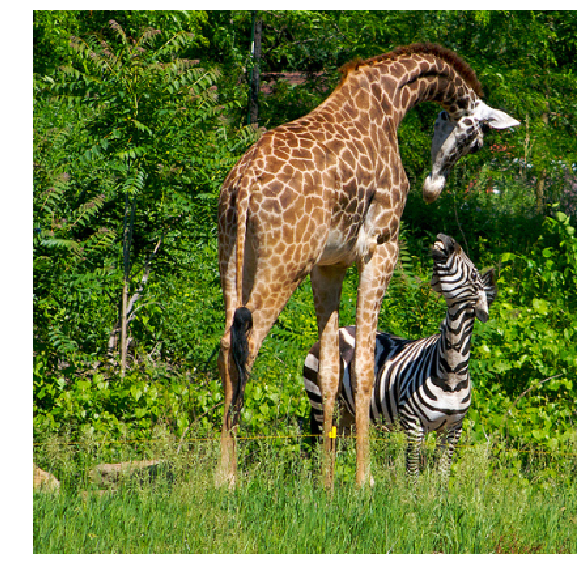

In [22]:
%matplotlib inline
image = load_image("images/giraffe.jpg")
plot_cv_image(image)
print(image.shape)

An image from file or camera typically has a dimension of (height, width, channel), for example (576, 768, 3), where 3 represents RGB channels. 

However, OpenCV YOLO model would need input of dimension of (number of images, channel, height, width). We can use [blobFromImage](https://docs.opencv.org/3.3.0/d6/d0f/group__dnn.html#ga0507466a789702eda8ffcdfa37f4d194) function to do the conversion for one image.

In [7]:
# detect a single image using the yolo_v3 model
def detect_image(yolo_model, single_image, output_layers):
    # construct a blob from the input image
    blob = cv2.dnn.blobFromImage(single_image, scalefactor=1 / 255.0, size=(416, 416), swapRB=True, crop=False)
    # perform a forward of the YOLO object detector
    yolo_model.setInput(blob)
    # output bounding boxes and associated probabilities
    yolo_outputs = yolo_model.forward(outBlobNames=output_layers)
    # outputs is a list of lenght 3, correspoding results from 3 YOLO layers, merge them together
    yolo_outputs = np.vstack(yolo_outputs)
    return yolo_outputs

In [23]:
start_time = time.time()
yolo_outputs = detect_image(yolo_v3, image, yolo_layers)
end_time = time.time()
print("YOLO took %.2f seconds." % (end_time - start_time))

YOLO took 0.68 seconds.


The outputs from YOLO model have a dimension of (10647, 85), because YOLO detects an image (416, 416) with three grid sizes: 13x13, 26x26 and 52x52 grids, where each grid box would have 3 results (3 anchor boxes). So for each image, we would have (13x13+26x26+52x52)x3 = 10647 detections.

For each box detection, YOLO would output 85 attributes: 

- The first 4 values of each object is the bounding box: center (x, y), followed by width and height, relative to the size of the image.
- The 5th value is the bounding box confidence.
- The following 80 values are class confidences, remember we have 80 classes on the COCO dataset.

As we can see, there are two many object detected, of which some are low confidence boxes, and some are overlapping boxes. We will need to filter and remove them.

Low confidence boxes can be removed by setting a threshold on bounding box confidence, while overlapping boxes can be removed by non maximum suppression using an OpenCV function [NMSBoxes](https://docs.opencv.org/4.1.0/d6/d0f/group__dnn.html#ga9d118d70a1659af729d01b10233213ee).

In [9]:
# filter yolo detection result, return a 2d array, with 7 columns: x,y,w,h,conf,class, class_conf
def filter_yolo_outputs(yolo_outputs, image_shape):
    # when there is no object detected, simply return empty array
    if len(yolo_outputs) == 0:
        return np.empty((0, 7))
    # only keep the boxes with confidence>0.5
    filtered = yolo_outputs[yolo_outputs[:, 4] > 0.5]
    # scale the bounding box coordinates back to pixels
    image_h, image_w, _ = image_shape
    filtered[:, 0:4] = filtered[:, 0:4] * np.array([image_w, image_h, image_w, image_h])
    # convert the center to the left-top corner
    filtered[:, 0] = filtered[:, 0] - filtered[:, 2] / 2
    filtered[:, 1] = filtered[:, 1] - filtered[:, 3] / 2
    # select the class with highest class confidence
    class_confidences = filtered[:, 5:].max(axis=1)
    class_ids = filtered[:, 5:].argmax(axis=1).astype(int)
    # apply non-maxima suppression to suppress weak, overlapping bounding boxes
    indices = cv2.dnn.NMSBoxes(filtered[:, 0:4].astype(int).tolist(), class_confidences.tolist(), score_threshold=0.5, nms_threshold=0.4)
    # if after non-maxima suppression, no detection was found, return empty result
    if len(indices) == 0:
        return np.empty((0, 7))
    indices = indices.flatten()
    # create new array to save the filtered detection results
    detections = np.zeros([indices.size, 7])
    detections[:, :5] = filtered[indices, :5]  # x,y,w,h,conf
    detections[:, 5] = class_ids[indices]  # class id
    detections[:, 6] = class_confidences[indices]  # class conf
    return detections

In [10]:
detections = filter_yolo_outputs(yolo_outputs, image.shape)
print("After filter, there are %d objects." % len(detections))

After filter, there are 2 objects.


In [11]:
# mark the image with detection results, by putting a box around the object, and a text of the object class
def mark_image(image, detections):
    # ensure at least one detection exists
    if detections.shape[0] == 0:
        return image
    # loop over the indexes we are keeping
    for obj in detections:
        # extract the bounding box coordinates
        x, y, w, h, _, class_id, _ = obj.astype(int)
        # draw a bounding box rectangle and label on the image
        color = colors[class_id].tolist()
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        class_name = coco_labels[class_id]
        cv2.putText(image, class_name, (x, y+h//2), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    return image

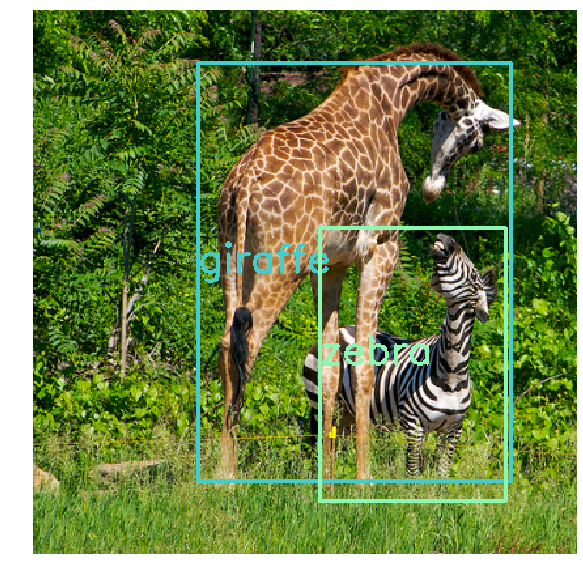

In [12]:
detection_image = mark_image(image, detections)
plot_cv_image(detection_image)

## Summary

Above are the codes needed to perform object detection using YOLO and OpenCV. Basically, 5 steps:

1. Load the YOLO model from configuration and weights.
2. Load an image.
3. Run the YOLO model on image(s).
4. Filter the detection result by removing low confidence boxes and non maximum suppression.
5. Plot the a marked image with boxes and class name.

Let's try with a different image:

After filter, there are 1 objects.
YOLO took 0.91 seconds.


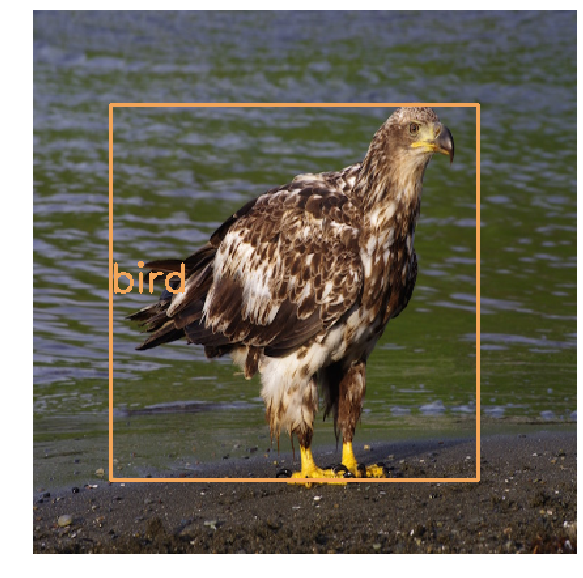

In [13]:
start_time = time.time()

# 1. Load the YOLO model from configuration and weights
# yolo_v3 = cv2.dnn.readNetFromDarknet("yolo_coco/yolov3.cfg", "yolo_coco/yolov3.weights")
# all_layers = yolo_v3.getLayerNames()
# yolo_layers = [all_layers[i - 1] for i in yolo_v3.getUnconnectedOutLayers().flatten()]
# 2. Load an image
image = load_image("images/eagle.jpg")
# 3. Run the YOLO model on image(s)
yolo_outputs = detect_image(yolo_v3, image, yolo_layers)
# 4. Filter the detection result by removing low confidence boxes and non maximum suppression.
detections = filter_yolo_outputs(yolo_outputs, image.shape)
print("After filter, there are %d objects." % len(detections))
#5. Plot the a marked image with boxes and class name.
detection_image = mark_image(image, detections)
plot_cv_image(detection_image)

end_time = time.time()
print("YOLO took %.2f seconds." % (end_time - start_time))

# Use YOLO to detect objects from a camera.

Using OpenCV's VideoCapture functions, we can grab an image from a camera, detect it using YOLO, filter the detection results, then show it, same steps as for a single image.

In [ ]:
start_time = time.time()
# 2. Load an image
image = load_image(0)
# 3. Run the YOLO model on image(s)
yolo_outputs = detect_image(yolo_v3, image, yolo_layers)
# 4. Filter the detection result by removing low confidence boxes and non maximum suppression.
detections = filter_yolo_outputs(yolo_outputs, image.shape)
print("After filter, there are %d objects." % len(detections))
#5. Plot the a marked image with boxes and class name.
detection_image = mark_image(image, detections)
plot_cv_image(detection_image)

end_time = time.time()
print("YOLO took %.2f seconds." % (end_time - start_time))

We can also wrap this in a while loop, so that we can detect image from cameras continuously. However, because Raspberry Pi has a low spec CPU, this would be very slow. I only got 0.3 FPS on a Raspberry Pi Model B. 

I also put motion detection in the code, so that we only run object detection when there is a change in the image content. 

In [15]:
# detect images from camera for a certain time
def detect_camera(camera_id, run_time=20):
    first_frame = None
    # create a matplotlib figure and turn on matplotlib interative plot mode
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.ion()
    fig.show()
    fig.canvas.draw()

    # run in a loop for certain time
    total_time = 0
    while True:
        start_time = time.time()
        #2. Load an image
        frame = load_image(camera_id)
        if frame is None:
            print("Camera read failed")
            break
        # covert to gray image, then blur it
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (21, 21), 0)
        if first_frame is None:
            first_frame = gray.copy()
            continue
        # compute the absolute difference between the current frame and first frame
        frame_delta = cv2.absdiff(first_frame, gray)
        thresh = cv2.threshold(frame_delta, 50, 255, cv2.THRESH_BINARY)[1]
        contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours)==2: #Opencv 4
            contours = contours[0]
        else: # OpenCV3 
            contours = contours[1]
        # if the contour is too small, ignore it
        contours = [c for c in contours if cv2.contourArea(c) > 2500]
        # so we find areas with larger size, detect the image using YOLO
        if len(contours):
            #3. Run the YOLO model on image(s)
            yolo_outputs = detect_image(yolo_v3, frame, yolo_layers)
            #4. Filter the detection result by removing low confidence boxes and non maximum suppression.
            detections = filter_yolo_outputs(yolo_outputs, frame.shape)
            #5. Plot the a marked image with boxes and class name.
            # here is a little different, because we want to update the same plot in a loop
            detection_image = mark_image(frame.copy(), detections)
            # convert OpenCV BGR to RGB for matplotlib
            image_rgb = cv2.cvtColor(detection_image, cv2.COLOR_BGR2RGB)
            # calculate time duration
            fps = 1/(time.time() - start_time)
        else:
            fps = 0
            image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # update the current plot with new image
        ax.clear()
        fig.suptitle('fps=%.2f, time remaining=%.2fs' % (fps, run_time - total_time), fontsize=20)
        fig.tight_layout()
        ax.imshow(image_rgb)
        ax.axis("off")
        fig.canvas.draw()
        # check how much used since begining.
        total_time += time.time() - start_time
        if total_time > run_time:
            break

In [ ]:
%matplotlib notebook
# Open camera 0 using OpenCV, if failed, check camera device id by run !ls /dev/|grep video
detect_camera(0, run_time=100)